In [ ]:
# default_exp core

# Core

> Download Kaggle data.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd

/home/mmb/miniconda3/envs/env_nbdev/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Data structure

In [ ]:
#export
path = Path('data/')

if not path.is_dir():
    path.mkdir(parents=True, exist_ok=True)

To easly view a directory `Path` structure, the `print_competition_data` function prints out this for you.

In [ ]:
#export
def print_competition_data(p:Path = path):
    for elem in p.ls():
        print(elem)

In [ ]:
print_competition_data(path)

data/codes.txt
data/sample_submission.csv
data/test_images
data/train.csv
data/train_images


The files in detail: 

- **train_images/** - folder of training images (12.5k images)
- **test_images/** - folder of test images to segment and classify (5506 images)
- **train.csv** - training annotations which provide segments for defects (`ClassId = [1, 2, 3, 4]`)
- **sample_submission.csv** - a sample submission file in the correct format; note, each `ImageId` 4 rows, one for each of the 4 defect classes


In [ ]:
#export
train_path = path/"train_images"
test_path  = path/"test_images"
train_pfiles = get_image_files(train_path)
test_pfiles  = get_image_files(test_path)

In [ ]:
test_pfiles

(#1) [Path('data/test_images/00a0b7730.jpg')]

## Training data

The training data is splitted in:

- faulty images: images that have at least one defect

- hard negative images: images with no defects

In [ ]:
train_pfiles

(#6) [Path('data/train_images/0a1cade03.jpg'),Path('data/train_images/72aaba8ad.jpg'),Path('data/train_images/988cf521f.jpg'),Path('data/train_images/b2ad335bf.jpg'),Path('data/train_images/b6a257b28.jpg'),Path('data/train_images/bca4ae758.jpg')]

In [ ]:
#export
def get_train_df(only_faulty=False):
    """
    Get training DataFrame with all the images in data/train_images.
    Returns only the faulty images if `only_faulty`.
    """
    train = pd.read_csv(path/"train.csv")
    train["ImageId_ClassId"] = train["ImageId"] + "_" + train["ClassId"].astype('str')
    if only_faulty: return train
    
    img_names = [ img_path.name for img_path in train_pfiles ]
    df_all = pd.DataFrame({'ImageId': img_names})
    train_all = pd.merge(df_all, train, on="ImageId", how="outer", indicator=True)
    # Renaming and fillna
    train_all.rename(columns={'_merge': 'status'}, inplace=True)
    rename_dict = {"both": "faulty", "left_only": "no_faulty"}
    train_all["status"] = train_all["status"].cat.rename_categories(rename_dict)
    train_all.ClassId.fillna(0, inplace=True)
    train_all.ClassId = train_all.ClassId.astype('int64')
    train_all.EncodedPixels.fillna(-1, inplace=True)    

    return train_all

### Faulty images

Each Image may have **no defects**, a defect of a **single class**, or **defects of multiple classes** (`ClassId`).

The `train.csv` file contains the informations about the faulty images. The columns are:

- **ImageId**: image name

- **ClassId**: the class type

- **EncodedPixels**: the encoded pixels follows a run-length encoding rule, a sequence of pair values that contains a start position and a run length with the space as the delimiter. E.g. `1 3 10 5` means pixels `(1,2,3)` and `(10,11,12,13,14)`.  

In [ ]:
#export
train = get_train_df(only_faulty=True)

In [ ]:
assert isinstance(train, pd.DataFrame)

In [ ]:
print(train.shape)
train.head(2)

(7095, 4)


,ImageId,ClassId,EncodedPixels,ImageId_ClassId
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,0002cc93b.jpg_1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63,0007a71bf.jpg_3


Every row of the DataFrame is a unique `(ImageId, ClassId)`. If there's duplicates the algorithms didn't work.

In [ ]:
assert not train.ImageId_ClassId.duplicated().any()

In [ ]:
train.dtypes

ImageId            object
ClassId             int64
EncodedPixels      object
ImageId_ClassId    object
dtype: object

In [ ]:
class_count = train["ClassId"].value_counts().sort_index()
class_count.index.set_names("ClassId", inplace=True)
class_count = class_count.to_frame()
class_count.rename(columns={"ClassId": "num"}, inplace=True)
class_count.assign(freq = lambda df: df["num"] / df["num"].sum())

,num,freq
ClassId,,
1,897,0.126427
2,247,0.034813
3,5150,0.725863
4,801,0.112896


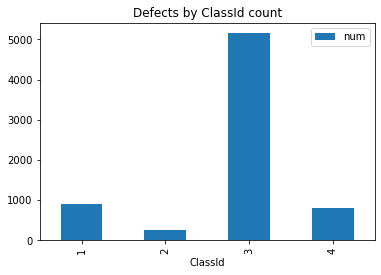

In [ ]:
class_count.plot.bar(title="Defects by ClassId count")
plt.show()

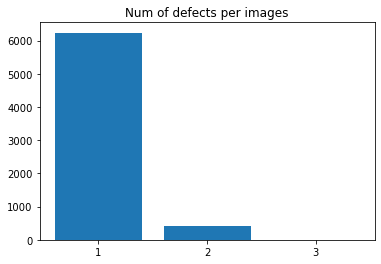

{1: 6239, 2: 425, 3: 2}

In [ ]:
counts = train["ImageId"].value_counts()
hist_counts, _ = np.histogram(counts.values, bins=3)
nums = ['1', '2', '3']
plt.bar(x=nums, height=hist_counts)
plt.title("Num of defects per images")
plt.show()

{i+1: c for i, c in enumerate(hist_counts)}

Images have at least one defect and there's a small number of images with two or three defects. 

In [ ]:
print("Multiple defects:")
imgs_class_agg = train.groupby("ImageId").apply(lambda x: x["ClassId"].values.tolist())

pairs = imgs_class_agg[imgs_class_agg.map(lambda v: len(v)==2)].values.tolist()
triples = imgs_class_agg[imgs_class_agg.map(lambda v: len(v)==3)].values.tolist()

p = Counter(map(lambda l: (l[0], l[1]), pairs))
t = Counter(map(lambda l: (l[0], l[1], l[2]), triples))

print("\n".join([f"ClassId {ids} counts {count} images" for ids, count in p.most_common()]))
print("\n".join([f"ClassId {ids} counts {count} images" for ids, count in t.most_common()]))

Multiple defects:
ClassId (3, 4) counts 284 images
ClassId (1, 3) counts 91 images
ClassId (1, 2) counts 35 images
ClassId (2, 3) counts 14 images
ClassId (2, 4) counts 1 images
ClassId (1, 2, 3) counts 2 images


### All training images

As we can see below, there're 7095 defects in 6666 images. 

In [ ]:
unique_imgs = train.describe(include='all')["ImageId"].T[:2]
unique_imgs

count     7095
unique    6666
Name: ImageId, dtype: object

In [ ]:
assert unique_imgs[0] == 7095
assert unique_imgs[1] == 6666

In [ ]:
#export
train_all = get_train_df()

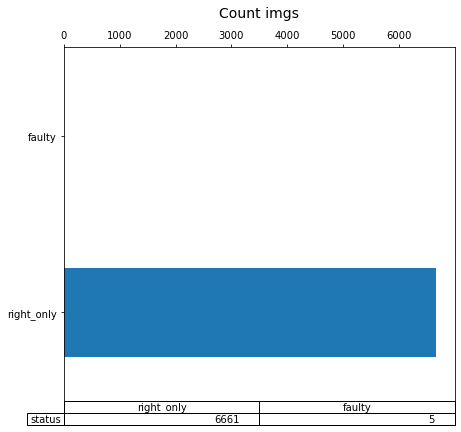

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title("Count imgs", pad=30, fontdict={'fontsize':14})
ax.xaxis.tick_top()  # Display x-axis ticks on top

(
    train_all[['ImageId', 'status']]
     .drop_duplicates()
     .status.value_counts().iloc[:-1]
     .plot.barh(table=True, ax=ax)
);

In [ ]:
train_all.dtypes

ImageId              object
ClassId               int64
EncodedPixels        object
ImageId_ClassId      object
status             category
dtype: object

In [ ]:
train_all.describe(include='all')[:4]

,ImageId,ClassId,EncodedPixels,ImageId_ClassId,status
count,7096,7096.0,7096,7095,7096
unique,6667,NaN,7096,7095,3
top,ef24da2ba.jpg,NaN,77270 43 77441 128 77612 12714 90369 128 90625 43 176918 3 177170 7 177422 11 177674 15 177926 20 178180 22 178436 22 178692 22 178948 22 179204 22 179460 23 179716 23 179972 23 180229 22 180485 22 180741 22 180997 23 181253 23 181509 23 181765 23 182021 23 182277 23 182533 23 182789 24 183045 24 183301 24 183557 24 183814 23 184070 23 184326 24 184582 24 184838 24 185094 24 185350 24 185606 24 185866 21 186128 15 186390 9 186652 3 378062 42 378276 84 378532 84 378788 84 379044 84 379300 84 379556 84 379812 84 380068 84 380324 84 380580 84 380836 84 381092 84 381348 84 381604 84 381860 84 ...,7f30a2a1e.jpg_3,right_only
freq,3,NaN,1,1,7090


In [ ]:
#export
def get_train_pivot(df=None):
    """
    Summarize the training csv with ClassId as columns and values EncodedPixels
    """
    if not df: df = train
    train_pivot = df.pivot(index="ImageId", columns="ClassId", values="EncodedPixels")
    train_pivot["n"] = train_pivot.notnull().sum(1)
    return train_pivot

In [ ]:
train_pivot = get_train_pivot()
train_pivot.head(2)

ClassId,1,2,3,4,n
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63,NaN,1


In [ ]:
#export
def get_classification_df(df:pd.DataFrame=None):
    """
    Get the DataFrame for the multiclass classification model
    """
    
    def assign_multi_ClassId(x):
        """Returns a string with multi ClassId sep with a blank space (' ')"""
        def fill_cols(c):
            return c.fillna(5).astype('int64').astype(str)

        cols = [fill_cols(x[i]) for i in range(5)]
        cols = [col.replace('5', '') for col in cols]
        ClassId_multi = cols[0] + " " + cols[1] + " " + cols[2] + " " + cols[3] + " " + cols[4]
        ClassId_multi = ClassId_multi.str.strip()
        ClassId_multi = ClassId_multi.str.replace('  ', ' ')

        return ClassId_multi.str.strip()

    if not df: df = train_all
    train_multi = df.pivot(index="ImageId", columns="ClassId", values="ClassId") 
    train_multi = train_multi.assign(ClassId_multi = lambda x: assign_multi_ClassId(x)) 
    return train_multi.reset_index()[["ImageId", "ClassId_multi"]]

In [ ]:
#export
train_multi = get_classification_df()

In [ ]:
train_multi.head()

ClassId,ImageId,ClassId_multi
0,0002cc93b.jpg,1
1,0007a71bf.jpg,3
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,4
4,0014fce06.jpg,3


Count of `ClassId` per image.

In [ ]:
train_multi["ClassId_multi"].value_counts()

3        4759
1         769
4         516
3 4       284
2         195
1 3        91
1 2        35
2 3        14
1 2 3       2
2 4         1
0           1
Name: ClassId_multi, dtype: int64

In [ ]:
train_multi.describe(include='all')

ClassId,ImageId,ClassId_multi
count,6667,6667
unique,6667,11
top,5d8c2d90e.jpg,3
freq,1,4759


In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_preprocessing.ipynb.
Converted index.ipynb.
